


#Import libraries

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# XGBoost (install if missing: pip install xgboost)

try:
  from xgboost import XGBClassifier
  HAS_XGB = True
except Exception:
  HAS_XGB = False

#Config

In [2]:
RANDOM_STATE = 42
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

#Load dataset

In [3]:
print("Loading Covertype dataset (this may take a few seconds)...")
data = fetch_covtype(as_frame=True)
X = data.data.copy()
y = data.target.copy() # labels are 1..7
# Human-friendly label names (per UCI Covertype docs)
COVER_LABELS = {
1: "Spruce/Fir",
2: "Lodgepole Pine",
3: "Ponderosa Pine",
4: "Cottonwood/Willow",
5: "Aspen",
6: "Douglas-fir",
7: "Krummholz",
}

Loading Covertype dataset (this may take a few seconds)...


#Basic EDA / sanity checks

In [4]:
print("Shape:", X.shape)
print("Classes:", np.unique(y).tolist())
print("Class distribution (counts):\n", y.value_counts().sort_index())


# Identify continuous vs. binary indicator columns
# Covertype feature order: 10 continuous + 4 Wilderness_Area + 40 Soil_Type
feature_names = X.columns.tolist()
continuous_cols = feature_names[:10]
wilderness_cols = feature_names[10:14]
soil_cols = feature_names[14:]


assert len(continuous_cols) == 10
assert len(wilderness_cols) == 4
assert len(soil_cols) == 40

Shape: (581012, 54)
Classes: [1, 2, 3, 4, 5, 6, 7]
Class distribution (counts):
 Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


#Train/validation split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

#Preprocessing

In [6]:
# Scale continuous features; pass-through one-hot/binary indicators
preprocess = ColumnTransformer(
transformers=[
("scale", StandardScaler(), continuous_cols),
("passthrough", "passthrough", wilderness_cols + soil_cols),
]
)

#Models

In [7]:
# Identify feature groups
continuous_cols = X.columns[:10].tolist()       # first 10 continuous features
wilderness_cols = X.columns[10:14].tolist()     # 4 wilderness indicators
soil_cols = X.columns[14:].tolist()             # 40 soil type indicators

# Preprocess: scale continuous, keep others as-is
preprocess = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), continuous_cols),
        ("passthrough", "passthrough", wilderness_cols + soil_cols),
    ]
)




models = {}


# 7.a Logistic Regression (multinomial baseline)
models["LogReg"] = Pipeline([
    ("prep", preprocess),
    (
        "clf",
        LogisticRegression(
            multi_class="multinomial",
            solver="saga",
            max_iter=200,
            n_jobs=-1,
            random_state=RANDOM_STATE,
        ),
    ),
])


# 7.b Random Forest (strong tree baseline)
models["RandomForest"] = Pipeline([
    ("prep", preprocess),
    (
        "clf",
        RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=RANDOM_STATE,
        ),
    ),
])


# 7.c XGBoost (if available)
if HAS_XGB:
    models["XGBoost"] = Pipeline([
        ("prep", preprocess),
        (
            "clf",
            XGBClassifier(
                objective="multi:softprob",
                num_class=7,
                n_estimators=600,
                learning_rate=0.05,
                max_depth=8,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_lambda=1.0,
                tree_method="hist",
                n_jobs=-1,
                random_state=RANDOM_STATE,
            ),
        ),
    ])
else:
   print("[Warning] xgboost not installed — skipping XGBoost model.")

#Train & Evaluate

In [8]:
# ================= Training & Evaluation =================
results = []
best_name = None
best_macro_f1 = -np.inf
best_pipeline = None

# Ensure labels are 0–6
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)  # y is your original label column
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

for name, pipe in models.items():
    print(f"\nTraining {name}...")

    # Use encoded labels for XGBoost
    if name == "XGBoost":
        pipe.named_steps["clf"].set_params(num_class=len(COVER_LABELS))
        pipe.fit(X_train, y_train_enc)
        y_pred = pipe.predict(X_test)
        y_pred = le.inverse_transform(y_pred)  # back to original labels
    else:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")

    # Report
    print(f"{name} — Accuracy: {acc:.4f} | Macro F1: {f1_macro:.4f}")
    print("Classification report:\n",
          classification_report(
              y_test,
              y_pred,
              digits=4,
              target_names=[COVER_LABELS[i] for i in sorted(COVER_LABELS.keys())]
          ))

    # Save results
    results.append({
        "model": name,
        "accuracy": acc,
        "f1_macro": f1_macro
    })

    # Track best model (by macro-F1)
    if f1_macro > best_macro_f1:
        best_macro_f1 = f1_macro
        best_name = name
        best_pipeline = pipe

# Save results table
results_df = pd.DataFrame(results).sort_values("f1_macro", ascending=False)
results_path = OUTPUT_DIR / "model_results.csv"
results_df.to_csv(results_path, index=False)

print(f"\nSaved results to {results_path}")
print(results_df)



Training LogReg...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogReg — Accuracy: 0.7235 | Macro F1: 0.5307
Classification report:
                    precision    recall  f1-score   support

       Spruce/Fir     0.7109    0.6972    0.7040     42368
   Lodgepole Pine     0.7463    0.7999    0.7722     56661
   Ponderosa Pine     0.6787    0.8018    0.7352      7151
Cottonwood/Willow     0.6103    0.4335    0.5069       549
            Aspen     0.1406    0.0047    0.0092      1899
      Douglas-fir     0.4964    0.2744    0.3534      3473
        Krummholz     0.7357    0.5570    0.6340      4102

         accuracy                         0.7235    116203
        macro avg     0.5884    0.5098    0.5307    116203
     weighted avg     0.7109    0.7235    0.7139    116203


Training RandomForest...
RandomForest — Accuracy: 0.9551 | Macro F1: 0.9253
Classification report:
                    precision    recall  f1-score   support

       Spruce/Fir     0.9656    0.9431    0.9542     42368
   Lodgepole Pine     0.9499    0.9744    0.9620     56661


#Confusion Matrix (best model)


Best model by Macro F1: RandomForest (0.9253)


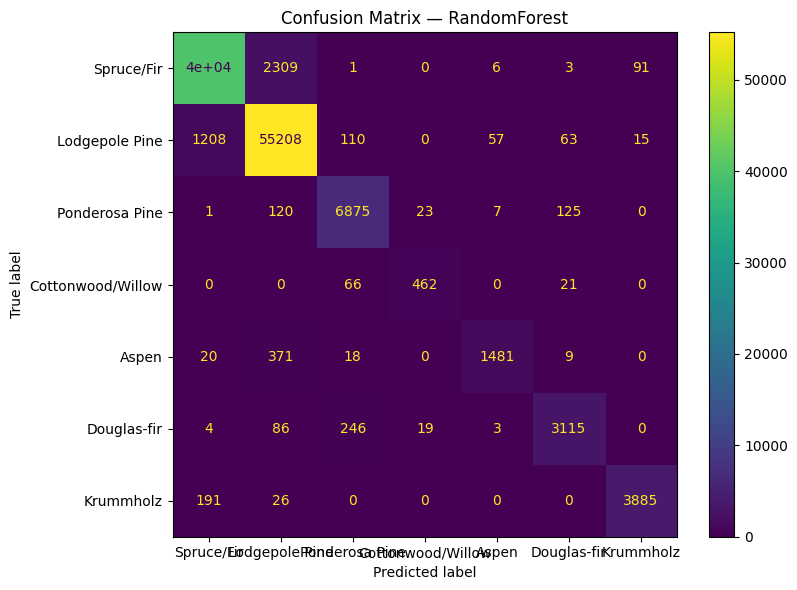

In [12]:
print(f"\nBest model by Macro F1: {best_name} ({best_macro_f1:.4f})")
y_pred_best = best_pipeline.predict(X_test)
fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
labels = [COVER_LABELS[i] for i in sorted(COVER_LABELS)]
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_best,
    display_labels=labels,
    ax=ax_cm,
    colorbar=True,
)
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout()


#Feature Importance (tree models)

Saved feature importance plot to outputs/feature_importance_RandomForest.png
Saved feature importance table to outputs/feature_importance_RandomForest.csv

Done.


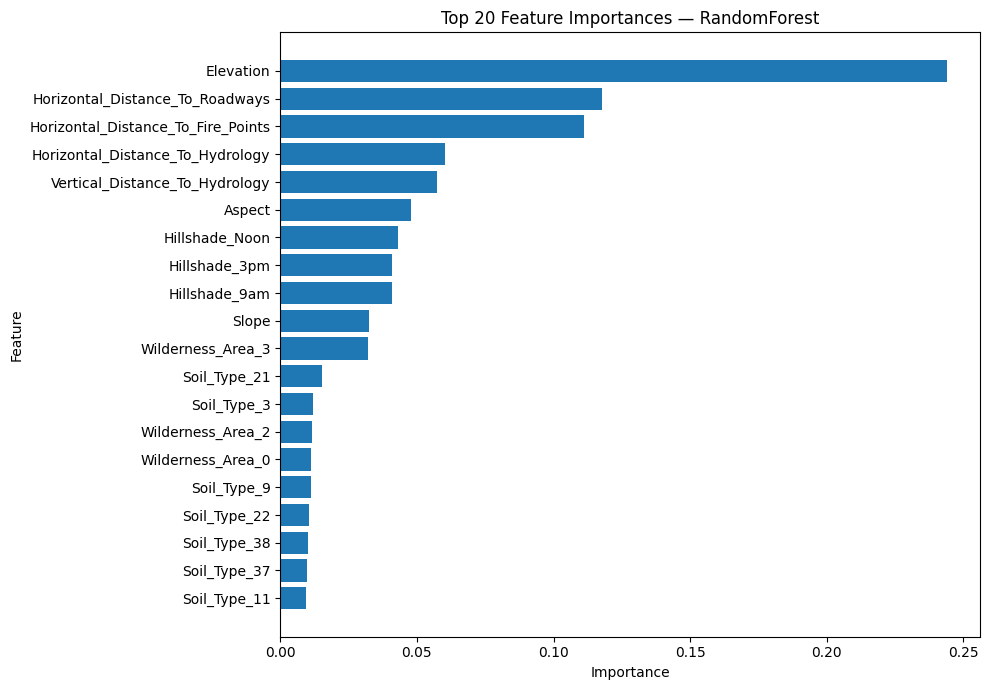

In [14]:
# We can extract feature importances from the underlying estimator.
# Because we used a ColumnTransformer + Pipeline, we must rebuild the full feature name list
# after preprocessing: 10 scaled continuous + 44 passthrough indicators (names preserved).

full_feature_names = continuous_cols + wilderness_cols + soil_cols


if best_name in ("RandomForest", "XGBoost"):
    clf = best_pipeline.named_steps["clf"]


# XGBoost exposes feature_importances_ (gain-based by default) or get_booster().get_score()
    if HAS_XGB and isinstance(clf, XGBClassifier):
        importances = clf.feature_importances_
    else:
# RandomForest
        importances = clf.feature_importances_


    fi = (
    pd.DataFrame({"feature": full_feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
    )


    top_k = 20
    fig_fi, ax_fi = plt.subplots(figsize=(10, 7))
    ax_fi.barh(fi.head(top_k)["feature"][::-1], fi.head(top_k)["importance"][::-1])
    ax_fi.set_xlabel("Importance")
    ax_fi.set_ylabel("Feature")
    ax_fi.set_title(f"Top {top_k} Feature Importances — {best_name}")
    plt.tight_layout()
    fi_path = OUTPUT_DIR / f"feature_importance_{best_name}.png"
    fig_fi.savefig(fi_path, dpi=150)
    print(f"Saved feature importance plot to {fi_path}")


# Save table
    fi_path_csv = OUTPUT_DIR / f"feature_importance_{best_name}.csv"
    fi.to_csv(fi_path_csv, index=False)
    print(f"Saved feature importance table to {fi_path_csv}")


else:
    print("Best model is not tree-based; skipping feature importance plot.")


print("\nDone.")